# ai4 for health related matters

## dependencies

In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## dataset stuff

### read the dataset

In [26]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac = 1)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
118,63,1,4,130,330,1,2,132,1,1.8,1,3.0,7.0,3
132,29,1,2,130,204,0,2,202,0,0.0,1,0.0,3.0,0
249,62,1,2,128,208,1,2,140,0,0.0,1,0.0,3.0,0
241,41,0,2,126,306,0,0,163,0,0.0,1,0.0,3.0,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,42,1,3,130,180,0,0,150,0,0.0,1,0.0,3.0,0
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7.0,0
127,54,1,4,110,239,0,0,126,1,2.8,2,1.0,7.0,3
139,51,1,3,125,245,1,2,166,0,2.4,2,0.0,3.0,0


### train_test split

In [27]:
ratio = 0.9 # 90:10 train:test ratio
train_set = df.sample(frac=ratio)

# Dropping all those indexes from the dataframe that exists in the train_set
test_set = df.drop(train_set.index)
train_set.shape, test_set.shape

train_set
test_set

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
132,29,1,2,130,204,0,2,202,0,0.0,1,0.0,3.0,0
200,50,0,4,110,254,0,2,159,0,0.0,1,0.0,3.0,0
16,48,1,2,110,229,0,0,168,0,1.0,3,0.0,7.0,1
218,64,0,4,130,303,0,0,122,0,2.0,2,2.0,3.0,0
205,45,1,4,142,309,0,2,147,1,0.0,2,3.0,7.0,3
21,58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,0
171,53,1,4,142,226,0,2,111,1,0.0,1,0.0,7.0,0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,?,2
52,44,1,4,112,290,0,2,153,0,0.0,1,1.0,3.0,2
281,47,1,3,130,253,0,0,179,0,0.0,1,0.0,3.0,0


### formating

In [28]:
# import training dataset

# Clean column names
train_set.columns = train_set.columns.str.strip()

# Handle missing values represented by '?'
train_set = train_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
train_set = train_set.dropna()
train_set = train_set.astype(float)

# Split features and labels
X = train_set.drop("diagnosis", axis=1)
y = train_set["diagnosis"]

y = (y > 0.5).astype(float)  # Ensures only 0 or 1

# normalise featuress from minmax scaling (sklearn)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
inputs = torch.tensor(X_scaled, dtype=torch.float32)
targets = torch.tensor(y.values, dtype=torch.float32)

print(inputs.shape, targets.shape)

torch.Size([269, 13]) torch.Size([269])


In [29]:
# Clean column names
test_set.columns = test_set.columns.str.strip()

# Handle missing values represented by '?'
test_set = test_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
test_set = test_set.dropna()
test_set = test_set.astype(float)

# Split features and labels
X_test = test_set.drop("diagnosis", axis=1)
y_test = test_set["diagnosis"]
y_test = (y_test > 0.5).astype(float)  # Ensures only 0 or 1

# Use the same scaler as for training
X_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
test_tensor = torch.tensor(X_scaled, dtype=torch.float32)
test_target = torch.tensor(y_test.values, dtype=torch.float32)

print(test_tensor.shape, test_target.shape)

torch.Size([28, 13]) torch.Size([28])


## AI1

### setup/params

In [30]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26, 1)
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=26, out_features=1, bias=True)
)


### error calcs.

In [31]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
      

### training

In [32]:
# learning rate and epochs
epochs = 10000
lr = 0.005

Epoch [1/10000], Loss: 0.7099
Epoch [2/10000], Loss: 0.7096
Epoch [3/10000], Loss: 0.7093
Epoch [4/10000], Loss: 0.7090
Epoch [5/10000], Loss: 0.7087
Epoch [6/10000], Loss: 0.7084
Epoch [7/10000], Loss: 0.7081
Epoch [8/10000], Loss: 0.7079
Epoch [9/10000], Loss: 0.7076
Epoch [10/10000], Loss: 0.7073
Epoch [11/10000], Loss: 0.7070
Epoch [12/10000], Loss: 0.7067
Epoch [13/10000], Loss: 0.7065
Epoch [14/10000], Loss: 0.7062
Epoch [15/10000], Loss: 0.7059
Epoch [16/10000], Loss: 0.7057
Epoch [17/10000], Loss: 0.7054
Epoch [18/10000], Loss: 0.7051
Epoch [19/10000], Loss: 0.7049
Epoch [20/10000], Loss: 0.7046
Epoch [21/10000], Loss: 0.7043
Epoch [22/10000], Loss: 0.7041
Epoch [23/10000], Loss: 0.7038
Epoch [24/10000], Loss: 0.7036
Epoch [25/10000], Loss: 0.7033
Epoch [26/10000], Loss: 0.7031
Epoch [27/10000], Loss: 0.7028
Epoch [28/10000], Loss: 0.7026
Epoch [29/10000], Loss: 0.7023
Epoch [30/10000], Loss: 0.7021
Epoch [31/10000], Loss: 0.7019
Epoch [32/10000], Loss: 0.7016
Epoch [33/10000],

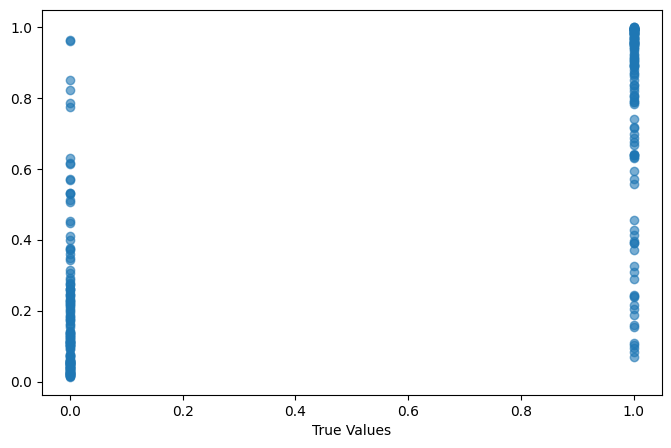

In [33]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

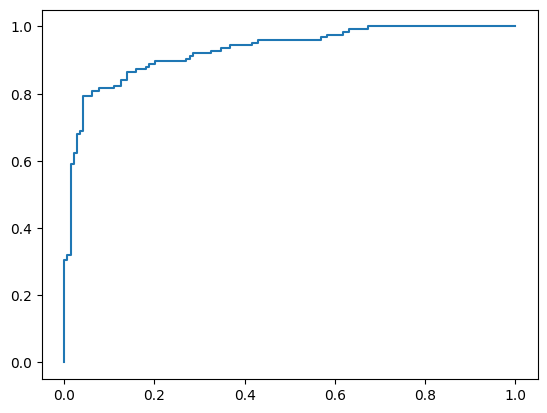

In [34]:
# roc curve
fpr1, tpr1, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr1, tpr1, label = "ROC Curve")

## AI2

### setup/params.

In [35]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.celu = nn.CELU()
        self.fc2 = nn.Linear(26, 32)
        self.rrelu2 = nn.RReLU()
        self.fc3 = nn.Linear(32, 26)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(26, 1) #output layer
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.celu(x)
        x = self.fc2(x)
        x = self.rrelu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
model

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (celu): CELU(alpha=1.0)
  (fc2): Linear(in_features=26, out_features=32, bias=True)
  (rrelu2): RReLU(lower=0.125, upper=0.3333333333333333)
  (fc3): Linear(in_features=32, out_features=26, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=26, out_features=1, bias=True)
)

### error calcs.

In [36]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
      

### training

In [37]:
# learning rate and epochs (variables)
epochs = 15000
lr = 0.02

Epoch [1/15000], Loss: 0.6926
Epoch [2/15000], Loss: 0.6927
Epoch [3/15000], Loss: 0.6925
Epoch [4/15000], Loss: 0.6924
Epoch [5/15000], Loss: 0.6925
Epoch [6/15000], Loss: 0.6924
Epoch [7/15000], Loss: 0.6924
Epoch [8/15000], Loss: 0.6925
Epoch [9/15000], Loss: 0.6924
Epoch [10/15000], Loss: 0.6922
Epoch [11/15000], Loss: 0.6923
Epoch [12/15000], Loss: 0.6922
Epoch [13/15000], Loss: 0.6923
Epoch [14/15000], Loss: 0.6922
Epoch [15/15000], Loss: 0.6921
Epoch [16/15000], Loss: 0.6922
Epoch [17/15000], Loss: 0.6920
Epoch [18/15000], Loss: 0.6921
Epoch [19/15000], Loss: 0.6921
Epoch [20/15000], Loss: 0.6921
Epoch [21/15000], Loss: 0.6920
Epoch [22/15000], Loss: 0.6921
Epoch [23/15000], Loss: 0.6920
Epoch [24/15000], Loss: 0.6921
Epoch [25/15000], Loss: 0.6919
Epoch [26/15000], Loss: 0.6918
Epoch [27/15000], Loss: 0.6919
Epoch [28/15000], Loss: 0.6918
Epoch [29/15000], Loss: 0.6918
Epoch [30/15000], Loss: 0.6918
Epoch [31/15000], Loss: 0.6917
Epoch [32/15000], Loss: 0.6919
Epoch [33/15000],

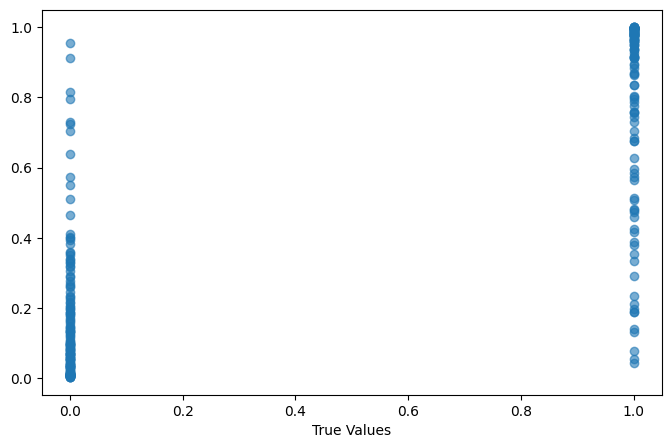

In [38]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

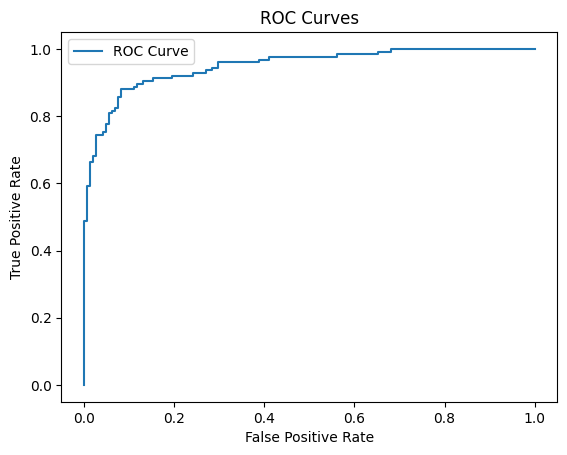

In [39]:
# roc curve
fpr2, tpr2, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr2, tpr2, label = "ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

## AI3

## comparison

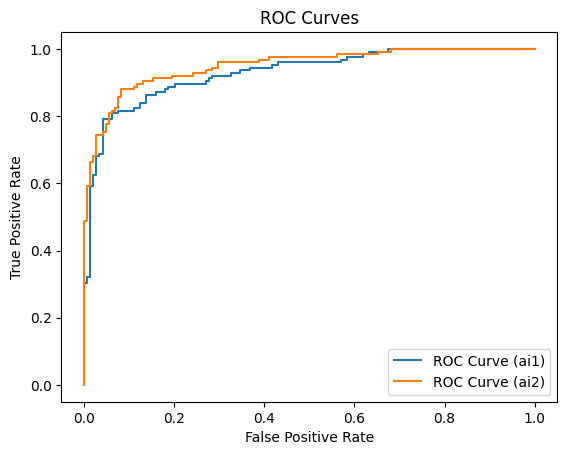

In [40]:
# roc curve
fpr2, tpr2, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr1, tpr1, label = "ROC Curve (ai1)") #blue
plt.plot(fpr2, tpr2, label = "ROC Curve (ai2)") #orange
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()